In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
from scipy.special import logsumexp
from scipy.spatial.distance import cdist
from particles import resampling as rs
import time
import importlib
import sys
sys.path.append('..')

import GaussianODEs as ode
importlib.reload(ode)

<module 'GaussianODEs' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/Gaussian/../GaussianODEs.py'>

In [2]:
d = 1

In [3]:
ms = 1*np.ones(d)
Sigmas = 5*np.eye(d)
mu0 = np.zeros(d)
Sigma0 = np.eye(d)

In [4]:
Sigmas_inv = linalg.inv(Sigmas)

In [5]:
def logpi_MultiGaussian(x, ms, Sigmas_inv):
    
    # Compute (x - m)
    xm = x - ms

    quad = np.sum(xm @ Sigmas_inv * xm, axis=1)
    
    return -0.5*quad

def SMC_WFR(gamma, Niter, ms, Sigmas, Sigmas_inv, X0, nmcmc):
    d = ms.size
    N = X0.shape[0]
    X = np.zeros((Niter, d, N))
    W = np.zeros((Niter, N))
    X[0, :] = X0.T
    W[0, :] = np.ones(N)/N
    for n in range(1, Niter):
        if (n > 1):
            # resample
            ancestors = rs.resampling('stratified', W[n-1, :])
            X[n-1, :, :] = X[n-1, :, ancestors].T
        # MCMC move
        if(nmcmc > 1):
            Xmcmc = np.zeros((nmcmc, d, N))
            Xmcmc[0, :] = X[n-1, :, :]
            for j in range(1, nmcmc):
                gradient_step = Xmcmc[j-1, :] - gamma*np.matmul(Sigmas_inv, (Xmcmc[j-1, :].T-ms).T)
                Xmcmc[j, :] = gradient_step + np.sqrt(2*gamma)*np.random.normal(size = (d, N))
            X[n, :] = Xmcmc[nmcmc-1, :]
        else:
            gradient_step = X[n-1, :, :] - gamma*np.matmul(Sigmas_inv, (X[n-1, :, :].T-ms).T)
            X[n, :, :] = gradient_step + np.sqrt(2*gamma)*np.random.normal(size = (d, N))
        distSq = -(1.0 / (4 * gamma))*cdist(X[n, :, :].T, gradient_step.T, metric='sqeuclidean')
#         Hinv = (4/(N*(d+2)))**(-2/(d+4))*np.diag(1/np.var(gradient_step, axis = 1))
#         distSq = -cdist(X[n, :, :].T, gradient_step.T, metric='mahalanobis', VI=Hinv)**2
        weight_denominator = logsumexp(distSq, axis=1)
        logW = (1-np.exp(-gamma))*(logpi_MultiGaussian(X[n, :, :].T, ms, Sigmas_inv)-weight_denominator)
        W[n, :] = rs.exp_and_normalise(logW)
    return X, W

def SMC_ULA(gamma, Niter, ms, Sigmas, Sigmas_inv, X0, nmcmc):
    d = ms.size
    N = X0.shape[0]
    X = np.zeros((Niter, d, N))
    X[0,:,:] = X0.T
    W = np.zeros((Niter, N))
    W[0, :] = np.ones(N)/N
    for n in range(1, Niter):
        if (n > 1):
            # resample
            ancestors = rs.resampling('stratified', W[n-1, :])
            X[n-1, :, :] = X[n-1, :, ancestors].T
        # MCMC move
        if(nmcmc > 1):
            Xmcmc = np.zeros((nmcmc, d, N))
            Xmcmc[0, :] = X[n-1, :, :]
            for j in range(1, nmcmc):
                gradient_step = Xmcmc[j-1, :] - gamma*np.matmul(Sigmas_inv, (Xmcmc[j-1, :].T-ms).T)
                Xmcmc[j, :] = gradient_step + np.sqrt(2*gamma)*np.random.normal(size = (d, N))
            X[n, :] = Xmcmc[nmcmc-1, :]
        else:
            gradient_step = X[n-1, :, :] - gamma*np.matmul(Sigmas_inv, (X[n-1, :, :].T-ms).T)
            X[n, :, :] = gradient_step + np.sqrt(2*gamma)*np.random.normal(size = (d, N))
        # reweight
        delta = (1-np.exp(-gamma))*np.exp(-(n-1)*gamma)
        logW = delta*(logpi_MultiGaussian(X[n, :, :].T, ms, Sigmas_inv) + 0.5*np.sum(X[n, :, :]**2, axis = 0))
        W[n, :] = rs.exp_and_normalise(logW)
    return X, W


def SMC_MALA(gamma, Niter, ms, Sigmas, Sigmas_inv, X0, nmcmc):
    d = ms.size
    N = X0.shape[0]
    X = np.zeros((Niter, d, N))
    X[0,:,:] = X0.T
    W = np.zeros((Niter, N))
    W[0, :] = np.ones(N)/N
    if(nmcmc > 1):
        accepted = np.zeros((Niter, N, nmcmc-1))
    else:
        accepted = np.zeros((Niter, N))
    for n in range(1, Niter):
        if (n > 1):
            # resample
            ancestors = rs.resampling('stratified', W[n-1, :])
            X[n-1, :, :] = X[n-1, :, ancestors].T
        # MCMC move
        if(nmcmc > 1):
            Xmcmc = np.zeros((nmcmc, d, N))
            Xmcmc[0, :] = X[n-1, :, :]
            for j in range(1, nmcmc):
                gradient_step = Xmcmc[j-1, :] - gamma*np.matmul(Sigmas_inv, (Xmcmc[j-1, :].T-ms).T)
                prop = gradient_step + np.sqrt(2*gamma)*np.random.normal(size = (d, N))
                Xmcmc[j, :], accepted[n, :, j-1] = mala_accept_reject(prop, Xmcmc[j-1, :], ms, Sigmas, Sigmas_inv, gamma)
            X[n, :] = Xmcmc[nmcmc-1, :]
        else:
            gradient_step = X[n-1, :, :] - gamma*np.matmul(Sigmas_inv, (X[n-1, :, :].T-ms).T)
            prop = gradient_step + np.sqrt(2*gamma)*np.random.normal(size = (d, N))
            X[n, :, :], accepted[n, :] = mala_accept_reject(prop, X[n-1, :, :], ms, Sigmas, Sigmas_inv, gamma)
        # reweight
        delta = np.exp(-(n-1)*gamma)
        logW = delta*(logpi_MultiGaussian(X[n-1, :, :].T, ms, Sigmas_inv) +0.5*np.sum(X[n-1, :, :]**2, axis = 0)) - delta*np.exp(-gamma)*(logpi_MultiGaussian(X[n, :, :].T, ms, Sigmas_inv) +0.5*np.sum(X[n, :, :]**2, axis = 0))
        W[n, :] = rs.exp_and_normalise(logW)
    return X, W, accepted

def mala_accept_reject(prop, v, ms, Sigmas, Sigmas_inv, gamma):
    d = ms.size
    gradient_prop = -np.matmul(Sigmas_inv, (prop.T-ms).T)
    gradient_v = -np.matmul(Sigmas_inv, (v.T-ms).T)
    log_proposal = multivariate_normal.logpdf((v-(prop+gamma*gradient_prop)).T, np.zeros(d), 2*gamma*np.eye(d))-multivariate_normal.logpdf((prop - (v+gamma*gradient_v)).T, np.zeros(d), 2*gamma*np.eye(d))
    log_acceptance = multivariate_normal.logpdf(prop.T, ms, Sigmas) - multivariate_normal.logpdf(v.T, ms, Sigmas) + log_proposal
    accepted = np.log(np.random.uniform(size = v.shape[1])) <= log_acceptance
    output = np.copy(v)
    output[:, accepted] = prop[:, accepted]
    return output, accepted

In [6]:
Niter = 40
gamma = 0.005
mean_eq_wfr, var_eq_wfr, kl_wfrinf = ode.wfr_infinite_time(mu0, ms, Sigma0, Sigmas, Niter, gamma)

In [7]:
N = 1000
X0 = np.random.normal(size = (d, N))

## SMC-WFR

In [8]:
x, W = SMC_WFR(gamma, Niter, ms, Sigmas, Sigmas_inv, X0.T, 1)

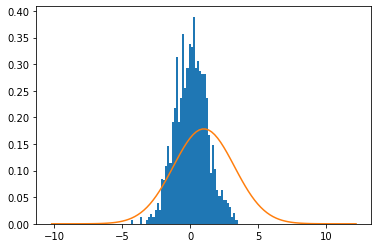

In [9]:
mu = ms[0]
sigma = Sigmas[0]

plt.hist(x[-1, 0, :], density = True, weights = W[-1, :], bins = 50)
plt.plot(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), norm.pdf(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), scale = np.sqrt(sigma), loc = mu))

In [10]:
mean_smcwfr = np.zeros(Niter)
var_smcwfr = np.zeros(Niter)
kl_smcwfr = np.zeros(Niter)
for i in range(Niter):
    mean_smcwfr[i] = np.sum(x[i, 0, :]*W[i, :])
    var_smcwfr[i] = np.sum(x[i, 0, :]**2*W[i, :]) - mean_smcwfr[i]**2
    kl_smcwfr[i] = ode.KL(mean_smcwfr[i], var_smcwfr[i], mu, sigma)

/var/folders/yb/2yx4lkb90l57vb9ljkzffpq40000gn/T/ipykernel_27741/4225333702.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl_smcwfr[i] = ode.KL(mean_smcwfr[i], var_smcwfr[i], mu, sigma)


## SMC-ULA

In [11]:
x, W = SMC_ULA(gamma, Niter, ms, Sigmas, Sigmas_inv, X0.T, 1)

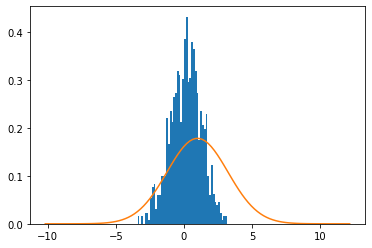

In [12]:
plt.hist(x[-1, 0, :], density = True, weights = W[-1, :], bins = 50)
plt.plot(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), norm.pdf(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), scale = np.sqrt(sigma), loc = mu))

In [13]:
mean_smcula = np.zeros(Niter)
var_smcula = np.zeros(Niter)
kl_smcula = np.zeros(Niter)
for i in range(Niter):
    mean_smcula[i] = np.sum(x[i, 0, :]*W[i, :])
    var_smcula[i] = np.sum(x[i, 0, :]**2*W[i, :]) - mean_smcula[i]**2
    kl_smcula[i] = ode.KL(mean_smcula[i], var_smcula[i], mu, sigma)

/var/folders/yb/2yx4lkb90l57vb9ljkzffpq40000gn/T/ipykernel_27741/2232707692.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl_smcula[i] = ode.KL(mean_smcula[i], var_smcula[i], mu, sigma)


## SMC-MALA

In [14]:
x, W, _ = SMC_MALA(gamma, Niter, ms, Sigmas, Sigmas_inv, X0.T, 1)

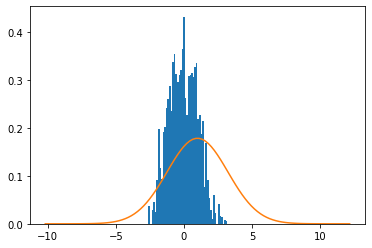

In [15]:
plt.hist(x[-1, 0, :], density = True, weights = W[-1, :], bins = 50)
plt.plot(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), norm.pdf(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), scale = np.sqrt(sigma), loc = mu))

In [16]:
mean_smcmala = np.zeros(Niter)
var_smcmala = np.zeros(Niter)
kl_smcmala = np.zeros(Niter)
for i in range(Niter):
    mean_smcmala[i] = np.sum(x[i, 0, :]*W[i, :])
    var_smcmala[i] = np.sum(x[i, 0, :]**2*W[i, :]) - mean_smcmala[i]**2
    kl_smcmala[i] = ode.KL(mean_smcmala[i], var_smcmala[i], mu, sigma)

/var/folders/yb/2yx4lkb90l57vb9ljkzffpq40000gn/T/ipykernel_27741/2185319381.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl_smcmala[i] = ode.KL(mean_smcmala[i], var_smcmala[i], mu, sigma)


Text(0, 0.5, 'KL$_t$')

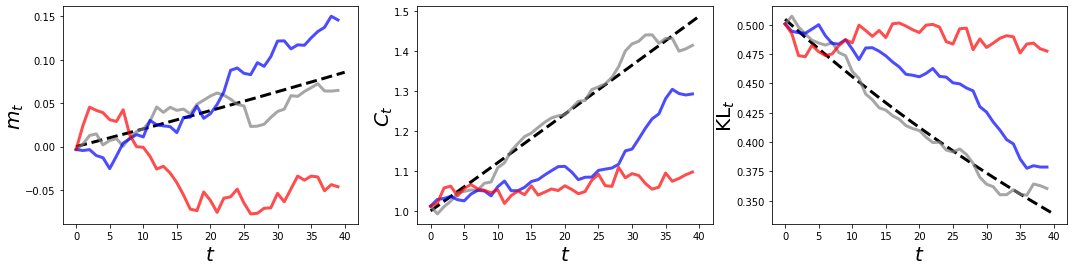

In [17]:
plt.figure(figsize = (18, 4))
plt.subplot(1, 3, 1)
plt.plot(mean_eq_wfr, label = 'WFR', linestyle = 'dashed', lw = 3, color = 'black')
plt.plot(mean_smcwfr, label = 'SMC-WFR', color = 'gray', alpha = 0.7, lw = 3)
plt.plot(mean_smcula, label = 'SMC-ULA', color = 'blue', alpha = 0.7, lw = 3)
plt.plot(mean_smcmala, label = 'SMC-MALA', color = 'red', alpha = 0.7, lw = 3)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$m_t$', fontsize = 20, labelpad=-1)
# plt.legend(fontsize = 20)
plt.subplot(1, 3, 2)
plt.plot(var_eq_wfr, label = 'WFR', linestyle = 'dashed', lw = 3, color = 'black')
plt.plot(var_smcwfr, label = 'SMC-WFR', color = 'gray', alpha = 0.7, lw = 3)
plt.plot(var_smcula, label = 'SMC-ULA', color = 'blue', alpha = 0.7, lw = 3)
plt.plot(var_smcmala, label = 'SMC-MALA', color = 'red', alpha = 0.7, lw = 3)
# plt.legend(fontsize = 20)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$C_t$', fontsize = 20, labelpad=-1)
plt.subplot(1, 3, 3)
plt.plot(kl_wfrinf, label = 'WFR', linestyle = 'dashed', lw = 3, color = 'black')
plt.plot(kl_smcwfr, label = 'SMC-WFR', color = 'gray', alpha = 0.7, lw = 3)
plt.plot(kl_smcula, label = 'SMC-ULA', color = 'blue', alpha = 0.7, lw = 3)
plt.plot(kl_smcmala, label = 'SMC-MALA', color = 'red', alpha = 0.7, lw = 3)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('KL$_t$', fontsize = 20, labelpad=-1)
# legend = plt.legend(loc = 'lower center', bbox_to_anchor=(-1, -0.5), ncol = 6, fontsize = 20)
# plt.savefig('SMC_WFR_gaussian_alternatives_target1.pdf', bbox_inches="tight")

Text(0, 0.5, 'KL$_t$')

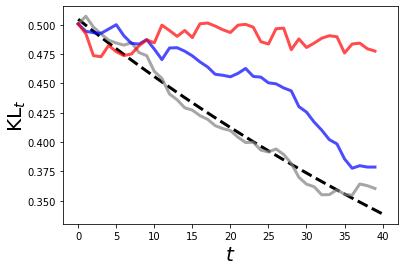

In [18]:
plt.plot(kl_wfrinf, label = 'WFR', linestyle = 'dashed', lw = 3, color = 'black')
plt.plot(kl_smcwfr, label = 'SMC-WFR', color = 'gray', alpha = 0.7, lw = 3)
plt.plot(kl_smcula, label = 'SMC-ULA', color = 'blue', alpha = 0.7, lw = 3)
plt.plot(kl_smcmala, label = 'SMC-MALA', color = 'red', alpha = 0.7, lw = 3)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('KL$_t$', fontsize = 20, labelpad=-1)
# legend = plt.legend(loc = 'lower center', bbox_to_anchor=(-1, -0.5), ncol = 6, fontsize = 20)
# plt.savefig('SMC_WFR_gaussian_alternatives_target2.pdf', bbox_inches="tight")

In [19]:
# def export_legend(legend, filename="legend_smc.pdf", expand=[-5,-5,5,5]):
#     fig  = legend.figure
#     fig.canvas.draw()
#     bbox  = legend.get_window_extent()
#     bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
#     bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
#     fig.savefig(filename, dpi="figure", bbox_inches=bbox)

# export_legend(legend)
# plt.show()